In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from ML2_lib import models
from ML2_lib import SGDByTorch
import torch.nn.functional as F
import torch
from sklearn.preprocessing import LabelBinarizer


In [2]:
pd.read_csv("data/adult/adult_classification.csv", header=None)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [3]:
def make_col_names():
    col_names = []
    continuous_dict = {}
    for i, line in enumerate(open("data/adult/adult_classification.names", "r"), 1):
        # :TODO この96は何？
        if i > 96:
            line = line.rstrip()
            name = line.split(":")[0]
            col_names.append(name)
            line = line.replace(" ", "").replace(".", "")
            continuous = line.split(":")[1] == "continuous"
            continuous_dict[name] = continuous
    col_names.append("label")
    continuous_dict["label"] = False
    return col_names, continuous_dict

In [4]:
n_id = 0
col_names, continuous_dicts = make_col_names()
col_names

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital-gain',
 'capital-loss',
 'hours-per-week',
 'native-country',
 'label']

In [5]:
def load_data(filename, col_names, n, skiprows=None):
    df = pd.read_csv(filename, header=None, index_col=None, skiprows=skiprows)
    # Display the number of records before delete missing valeus.
    print("the number of {} records:{}\n".format(filename, len(df.index)))
    df.columns = col_names

    # Replace the missing value's character to np.nan.
    df = df.applymap(lambda d: np.nan if d == " ?" else d)

    # Unify the different written forms.
    df = df.applymap(lambda d: " <=50K" if d == " <=50K." else d)
    df = df.applymap(lambda d: " >50K" if d == " >50K." else d)

    # Display the information about missing values and
    print("missing value info:\n{}\n".format(df.isnull().sum(axis=0)))
    df = df.dropna(axis=0)

    # the number of records after delete missing valeus.
    print("the number of {} records after trimming:{}\n".format(filename, len(df.index)))
    ids = list(np.arange(n, n + len(df.index)))
    df["ID"] = np.array(ids)
    n = n + len(df.index)
    return df, n



In [6]:
df_train, n_id_train = load_data("data/adult/adult_classification.csv", col_names, n_id)
df_test, n_id_test = load_data("data/adult/adult_classification.test", col_names, n_id_train, skiprows=1)

the number of data/adult/adult_classification.csv records:32561

missing value info:
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
label                0
dtype: int64

the number of data/adult/adult_classification.csv records after trimming:30162

the number of data/adult/adult_classification.test records:16281

missing value info:
age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
label               0
dtype: int64

the number of data/adult/adult_classification.

In [7]:
def get_not_continuous_columns(continuous_dict):
    categorical_names = [k for k, v in continuous_dict.items() if not v]
    return categorical_names

In [8]:
def print_labelinfo(labelnames):
    for i in range(len(labelnames)):
        print("label{}:{}".format(i, labelnames[i]))

In [9]:
def convert_data(df_train, df_test, n_id_train, n_id_test, continuous_dicts):
    categorical_names = get_not_continuous_columns(continuous_dicts)
    df = pd.concat((df_train, df_test), axis=0)

    # Get the dummy for the categorical data.
    for name in categorical_names:
        print(name)
        if name == "label":
            # ここではOneHotEncordingではなくLabelEncording
            # F .nll_lossの関係で
            lb = LabelBinarizer()
            dummy_df = lb.fit_transform(df[name])
            df["label"] = dummy_df
        else:
            dummy_df = pd.get_dummies(df[name])
            df = pd.concat((df, dummy_df), axis=1)
            df = df.drop(name, axis=1)

    # Convert the data type.
    for name in df.columns:
        df[name] = df[name].astype(float)

    # Reguralize the data.
    for name in df.columns:
        if name == "ID":
            df[name] = df[name]
        else:
            df[name] = (df[name] - df[name].min()) / (df[name].max() - df[name].min())

    df_train = df[df["ID"] < n_id_train].drop("ID", axis=1)
    df_test = df[df["ID"] >= n_id_train].drop("ID", axis=1)

    y_train = df_train["label"].values
    y_test = df_test["label"].values
    X_train = df_train.drop("label", axis=1).values
    X_test = df_test.drop("label", axis=1).values
    return X_train, y_train, X_test, y_test

In [10]:
X_train, y_train, X_test, y_test = convert_data(df_train, df_test, n_id_train, n_id_test, continuous_dicts)
print("X_train:{} y_train:{} X_test:{} y_test:{}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

workclass
education
marital-status
occupation
relationship
race
sex
native-country
label
X_train:(30162, 104) y_train:(30162,) X_test:(15060, 104) y_test:(15060,)


In [11]:
w_dim = X_train.shape[1]
class_num = int(max(y_train) + 1)
unit_num = 5
model = models.Net(w_num=w_dim,c_num=class_num,unit_num=unit_num)

In [12]:
hoge = SGDByTorch.SGDTorch(lr=0.01)

In [13]:
sgd_model, stack, loss_stack, test_loss_stack,accuracy_stack = hoge.learn(x=X_train, y=y_train, model=model,class_num=class_num,X_test=X_test,Y_test=y_test)


step : 0
[[2008 9352]
 [ 949 2751]]
              precision    recall  f1-score   support

           0       0.68      0.18      0.28     11360
           1       0.23      0.74      0.35      3700

    accuracy                           0.32     15060
   macro avg       0.45      0.46      0.31     15060
weighted avg       0.57      0.32      0.30     15060

正解率 : 0.31600265604249667
step : 10
[[4607 6753]
 [1555 2145]]
              precision    recall  f1-score   support

           0       0.75      0.41      0.53     11360
           1       0.24      0.58      0.34      3700

    accuracy                           0.45     15060
   macro avg       0.49      0.49      0.43     15060
weighted avg       0.62      0.45      0.48     15060

正解率 : 0.44833997343957505
step : 20
[[6156 5204]
 [1859 1841]]
              precision    recall  f1-score   support

           0       0.77      0.54      0.64     11360
           1       0.26      0.50      0.34      3700

    accuracy        

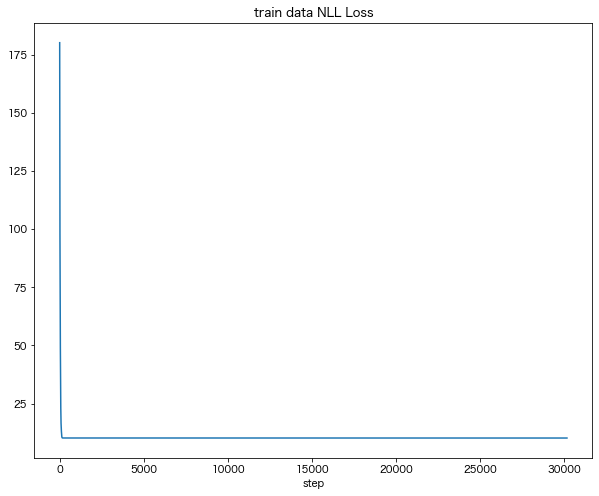

In [14]:

fig = plt.figure(figsize=(10.0, 8.0))
ax1 = fig.add_subplot(111)

ax1.set_title("train data NLL Loss")

ax1.plot(loss_stack)
ax1.set_xlabel("step")
plt.show()

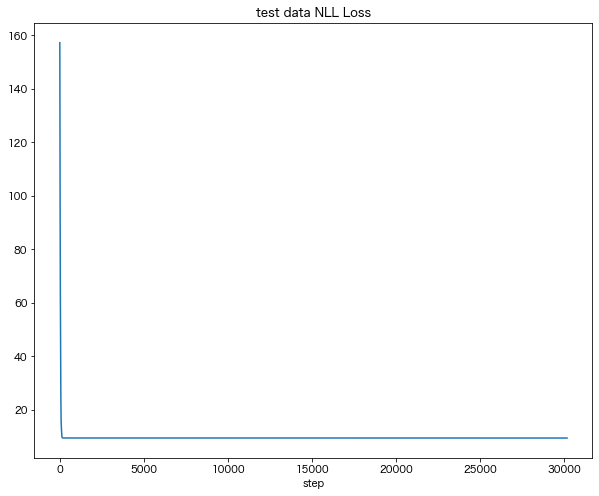

In [15]:
fig = plt.figure(figsize=(10.0, 8.0))
ax1 = fig.add_subplot(111)
ax1.set_title("test data NLL Loss")

ax1.plot(test_loss_stack)
ax1.set_xlabel("step")
plt.show()

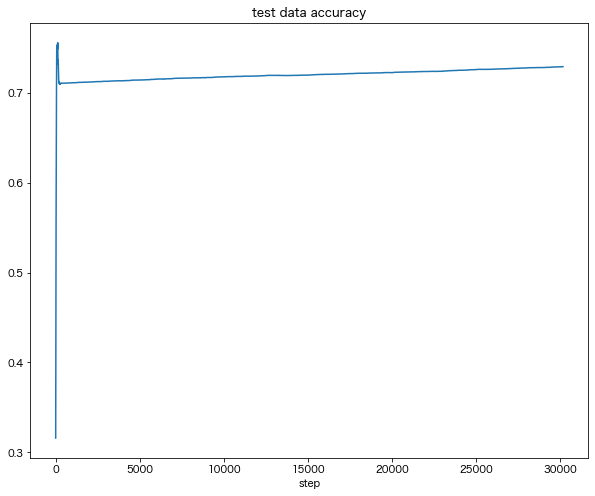

In [16]:
fig = plt.figure(figsize=(10.0, 8.0))
ax1 = fig.add_subplot(111)
ax1.set_title("test data accuracy")

ax1.plot(accuracy_stack)
ax1.set_xlabel("step")
plt.show()

In [17]:
sgd_model



Net(
  (fc1): Linear(in_features=104, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=2, bias=True)
  (relu): ReLU()
)

In [18]:
sgd_model(torch.Tensor(X_test).float())

tensor([[ -9.2457, -12.1096],
        [ -9.9074,  -9.1910],
        [ -9.8616,  -9.4450],
        ...,
        [-10.0813,  -8.4270],
        [ -9.6283, -10.4724],
        [-10.1642,  -8.2284]], grad_fn=<LogSoftmaxBackward>)

In [19]:

np.histogram(y_test)

(array([11360,     0,     0,     0,     0,     0,     0,     0,     0,
         3700]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))